In [138]:
import pandas as pd
import matplotlib.pyplot as plt

In [139]:
def plot_size(partition, precision):
    """
    Parameters:
        partition (str): The partition used (e.g., 'epyc', 'thin')
        precision (str): The computation precision (e.g., 'double', 'float')

    This function plots the runtime and GFLOPs for the three libraries and for both thread allocation policy.
    """
    libraries = ['oblas', 'mkl', 'blis']
    allocations = ['close', 'spread']

    runtime_data = []
    gflops_data = []

    if partition == 'epyc':
        if precision == 'float':
            tpp = [5324.8, 'TPP 5324.8']
        elif precision == 'double':
            tpp = [2662.4, 'TPP 2662.4']
    elif partition == 'thin':
        if precision == 'float':
            tpp = [1997, 'TPP 1997']
        elif precision == 'double':
            tpp = [998.5, 'TPP 998.5']

    for library in libraries:
        for allocation in allocations:
            file_path = f'data/{partition}/size/{allocation}/{precision}_{library}_size_{allocation}_results.csv'
            df = pd.read_csv(file_path)

            agg_data = df.groupby('size').agg(
                rt_mean=('runtime', 'mean'),
                rt_std=('runtime', 'std'),
                gf_mean=('GFLOPS', 'mean'),
                gf_std=('GFLOPS', 'std')
            ).reset_index()

            runtime_data.append((f"{library.upper()} ({allocation})", agg_data['size'], agg_data['rt_mean'], agg_data['rt_std']))
            gflops_data.append((f"{library.upper()} ({allocation})", agg_data['size'], agg_data['gf_mean'], agg_data['gf_std']))

    # Plot Runtime vs Size for both allocations
    plt.figure(figsize=(12, 6))
    for label, sizes, rt_means, rt_stds in runtime_data:
        plt.plot(sizes, rt_means, label=label, linestyle='-', marker='o')
        plt.fill_between(
            sizes,
            rt_means - rt_stds,
            rt_means + rt_stds,
            alpha=0.2
        )
    plt.title(f'Runtime vs Size ({partition}, {precision})')
    plt.xlabel('Size')
    plt.ylabel('Runtime (s)')
    plt.xticks(runtime_data[0][1])
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for label, sizes, gf_means, gf_stds in gflops_data:
        plt.plot(sizes, gf_means, label=label, linestyle='-', marker='o')
        plt.fill_between(
            sizes,
            gf_means - gf_stds,
            gf_means + gf_stds,
            alpha=0.2
        )

    plt.axhline(y=tpp[0], color='r', linestyle='--', label=tpp[1])
    plt.title(f'GFLOPS vs Size ({partition}, {precision})')
    plt.xlabel('Size')
    plt.ylabel('GFLOPS')
    plt.xticks(gflops_data[0][1])
    plt.legend()
    plt.grid(True)
    plt.show()

In [140]:
def plot_core(partition, precision):
    """
    Parameters:
        partition (str): The partition used (e.g., 'epyc', 'thin').
        precision (str): The computation precision (e.g., 'double', 'float').

    This function plots the runtime, GFLOPs, and speedup for the three libraries and for both thread allocation policy.
    """
    libraries = ['oblas', 'mkl', 'blis']
    allocations = ['close', 'spread']

    runtime_data = []
    gflops_data = []
    speedup_data = []

    for library in libraries:
        for allocation in allocations:
            # Load the CSV file
            file_path = f'data/{partition}/core/{allocation}/{precision}_{library}_core_{allocation}_results.csv'
            df = pd.read_csv(file_path)

            # Aggregate data (mean and std by threads)
            agg_data = df.groupby('threads').agg(
                rt_mean=('runtime', 'mean'),
                rt_std=('runtime', 'std'),
                gf_mean=('GFLOPS', 'mean'),
                gf_std=('GFLOPS', 'std')
            ).reset_index()

            # Compute speedup
            single_thread_runtime = agg_data.loc[agg_data['threads'] == 1, 'rt_mean'].values[0]
            agg_data['speedup_mean'] = single_thread_runtime / agg_data['rt_mean']
            agg_data['speedup_std'] = agg_data['rt_std'] / agg_data['rt_mean'] * agg_data['speedup_mean']

            runtime_data.append((f"{library.upper()} ({allocation})", agg_data['threads'], agg_data['rt_mean'], agg_data['rt_std']))
            gflops_data.append((f"{library.upper()} ({allocation})", agg_data['threads'], agg_data['gf_mean'], agg_data['gf_std']))
            speedup_data.append((f"{library.upper()} ({allocation})", agg_data['threads'], agg_data['speedup_mean'], agg_data['speedup_std']))

    # Combined Runtime Plot
    plt.figure(figsize=(14, 6))
    for label, threads, rt_means, rt_stds in runtime_data:
        plt.plot(threads, rt_means, label=label, linestyle='-', marker='o')
        plt.fill_between(
            threads,
            rt_means - rt_stds,
            rt_means + rt_stds,
            alpha=0.2
        )
    plt.title(f'Runtime vs Threads ({partition}, {precision})')
    plt.xlabel('Threads')
    plt.ylabel('Runtime (s)')
    plt.xticks(runtime_data[0][1])
    plt.legend()
    plt.grid(True)
    plt.show()

    # Combined GFLOPS Plot
    plt.figure(figsize=(14, 6))
    for label, threads, gf_means, gf_stds in gflops_data:
        plt.plot(threads, gf_means, label=label, linestyle='-', marker='o')
        plt.fill_between(
            threads,
            gf_means - gf_stds,
            gf_means + gf_stds,
            alpha=0.2
        )
    plt.title(f'GFLOPS vs Threads ({partition}, {precision})')
    plt.xlabel('Threads')
    plt.ylabel('GFLOPS')
    plt.xticks(gflops_data[0][1])
    plt.legend()
    plt.grid(True)
    plt.show()

    # Combined Speedup Plot
    plt.figure(figsize=(14, 6))
    for label, threads, speedup_means, speedup_stds in speedup_data:
        plt.plot(threads, speedup_means, label=label, linestyle='-', marker='o')
        plt.fill_between(
            threads,
            speedup_means - speedup_stds,
            speedup_means + speedup_stds,
            alpha=0.2
        )
    plt.plot(threads, threads, linestyle='--', color='r', label='Ideal Speedup') 
    plt.title(f'Speedup vs Threads ({partition}, {precision})')
    plt.xlabel('Threads')
    plt.ylabel('Speedup')
    plt.xticks(speedup_data[0][1])
    plt.legend()
    plt.grid(True)
    plt.show()

# EPYC

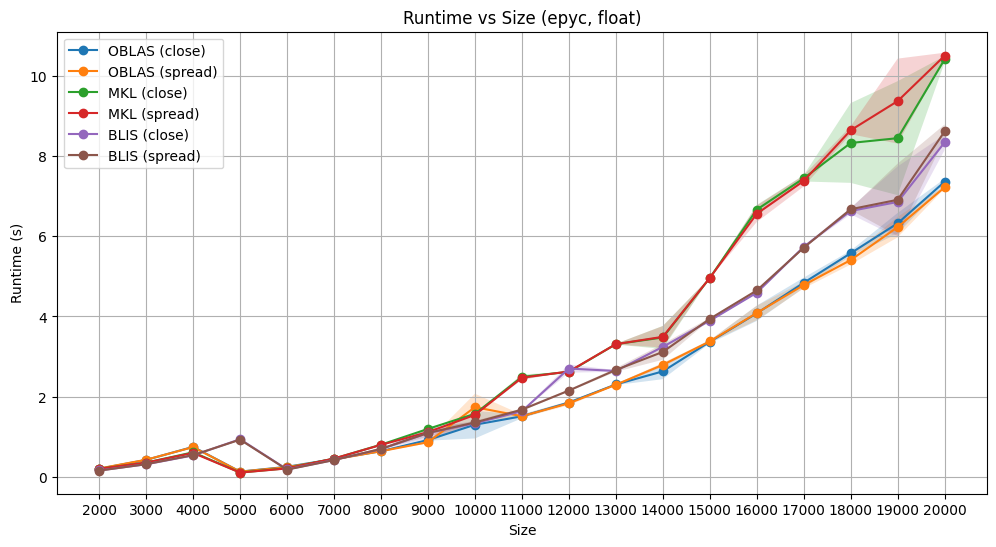

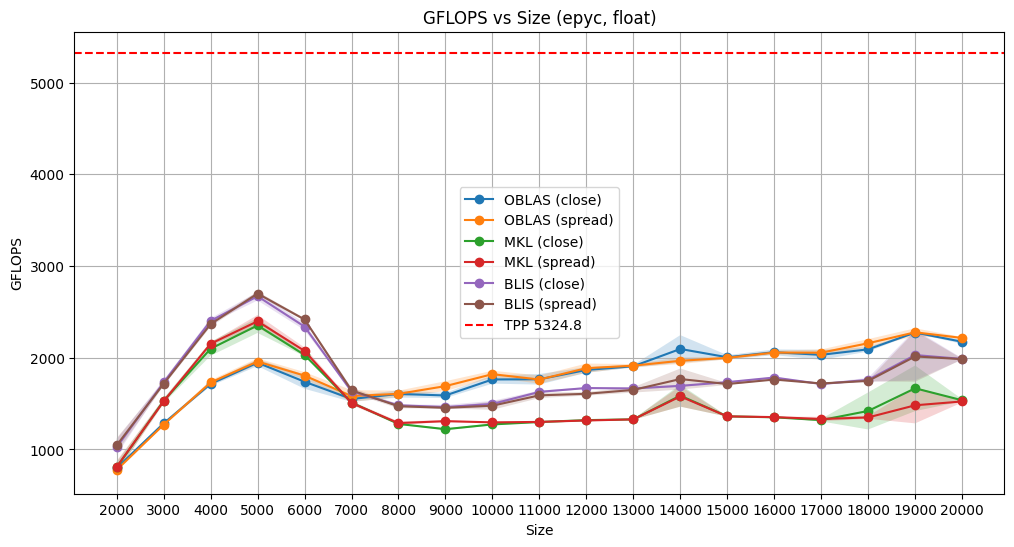

In [141]:
plot_size('epyc', 'float')

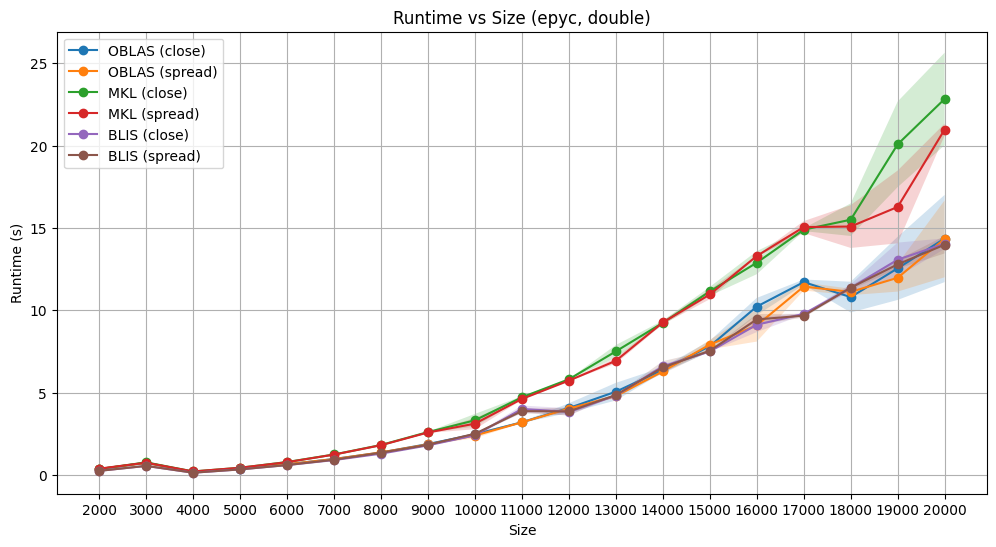

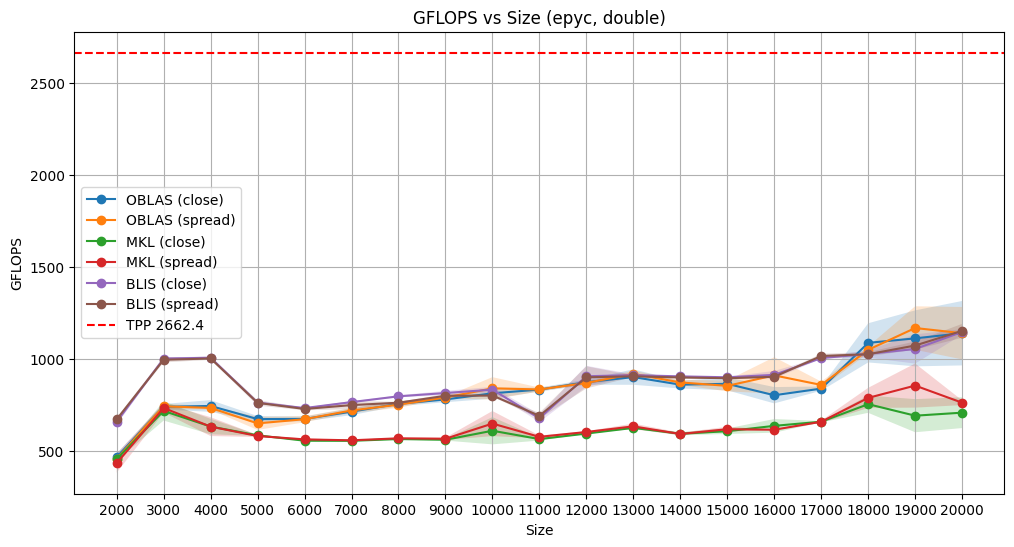

In [142]:
plot_size('epyc', 'double')

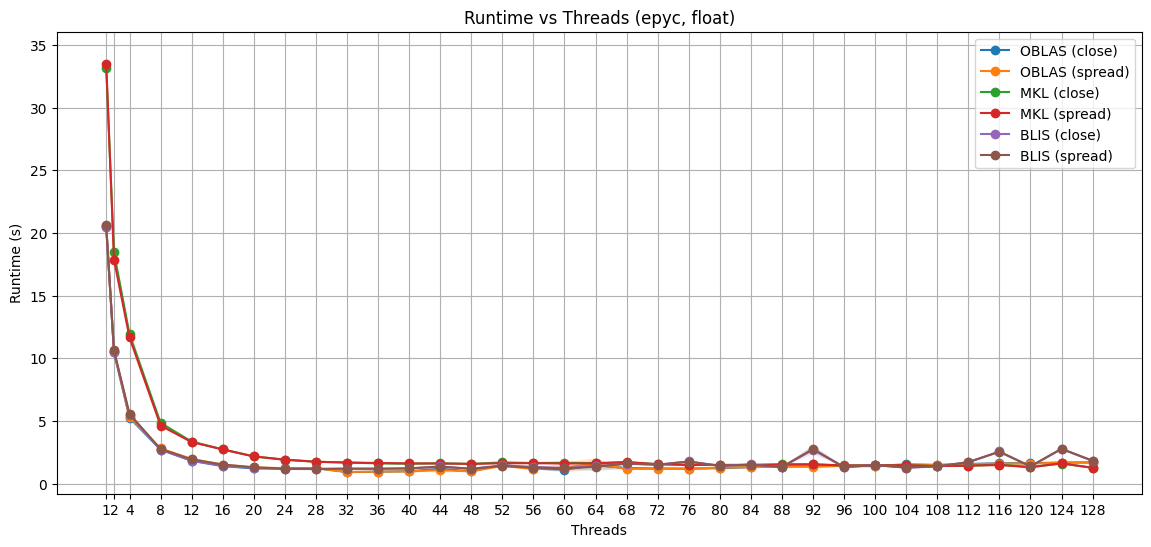

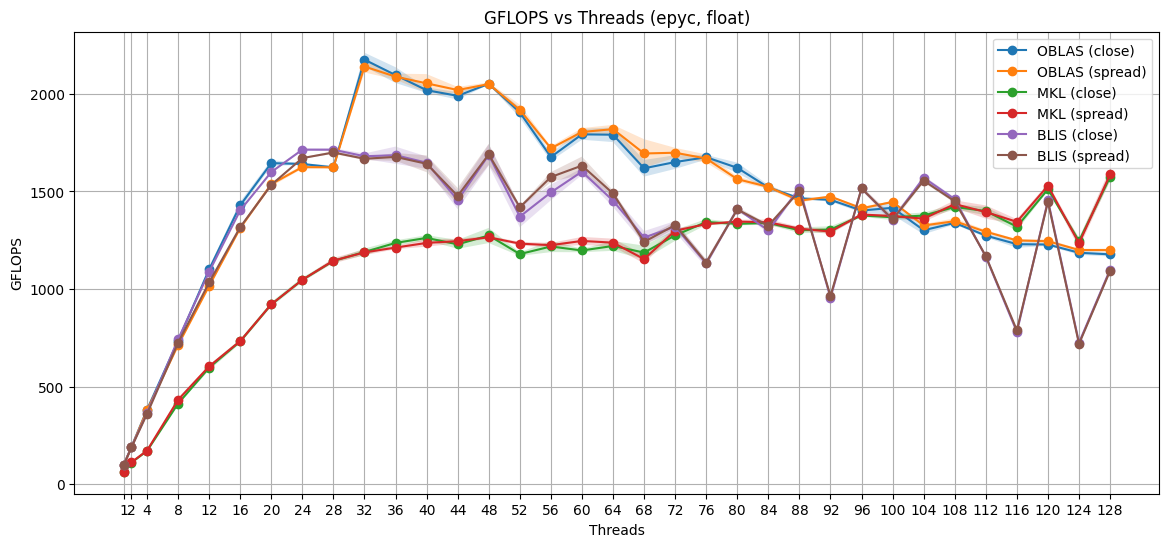

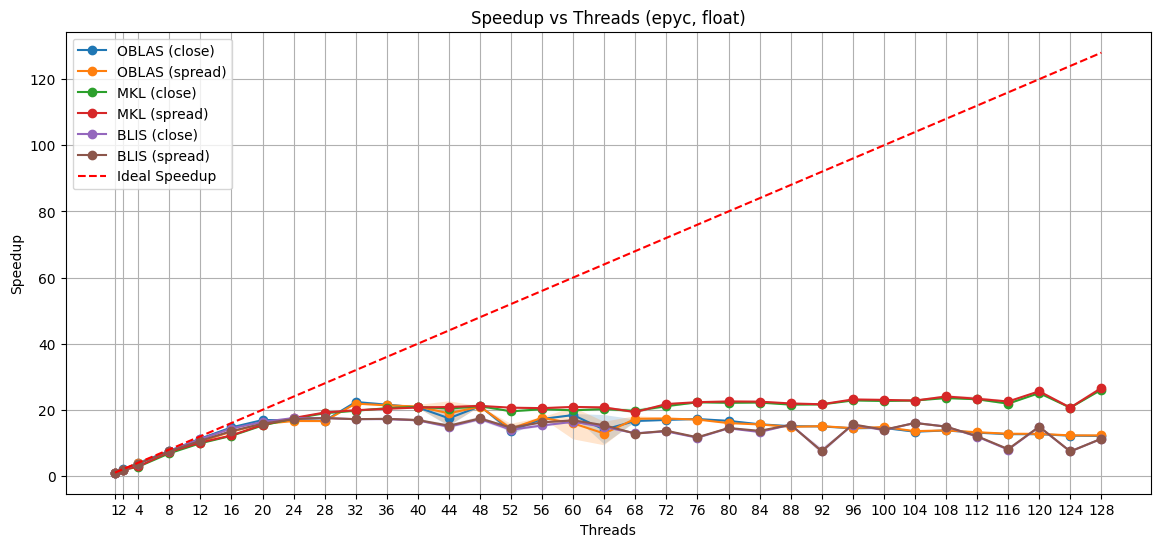

In [143]:
plot_core('epyc', 'float')

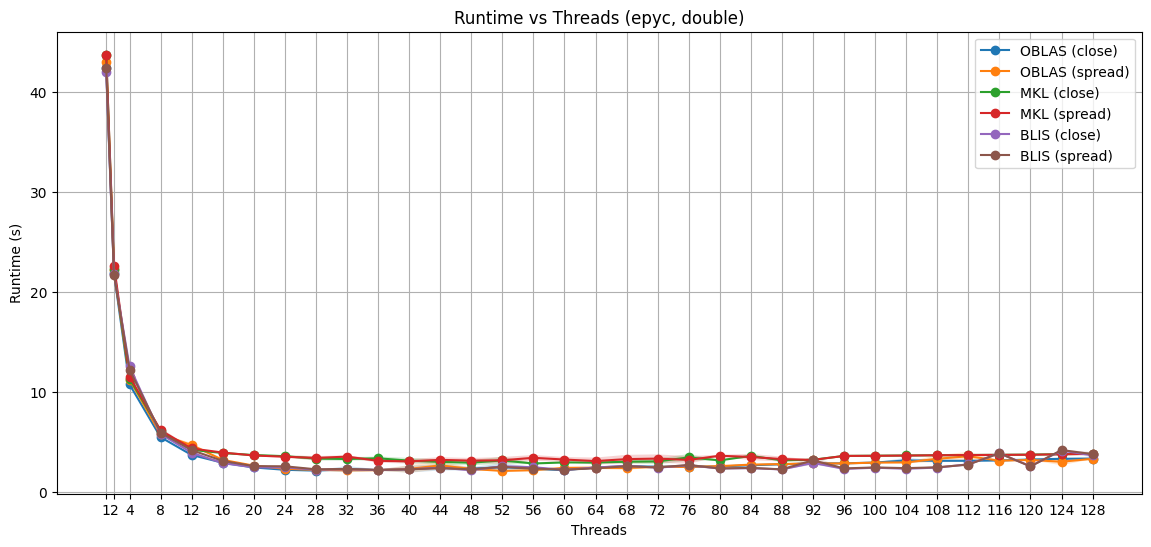

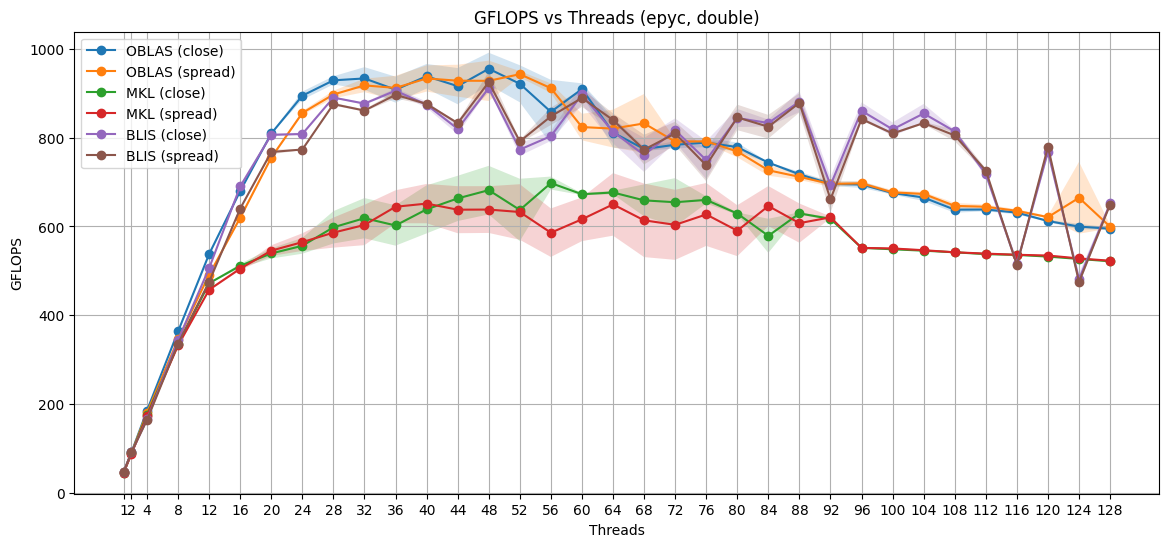

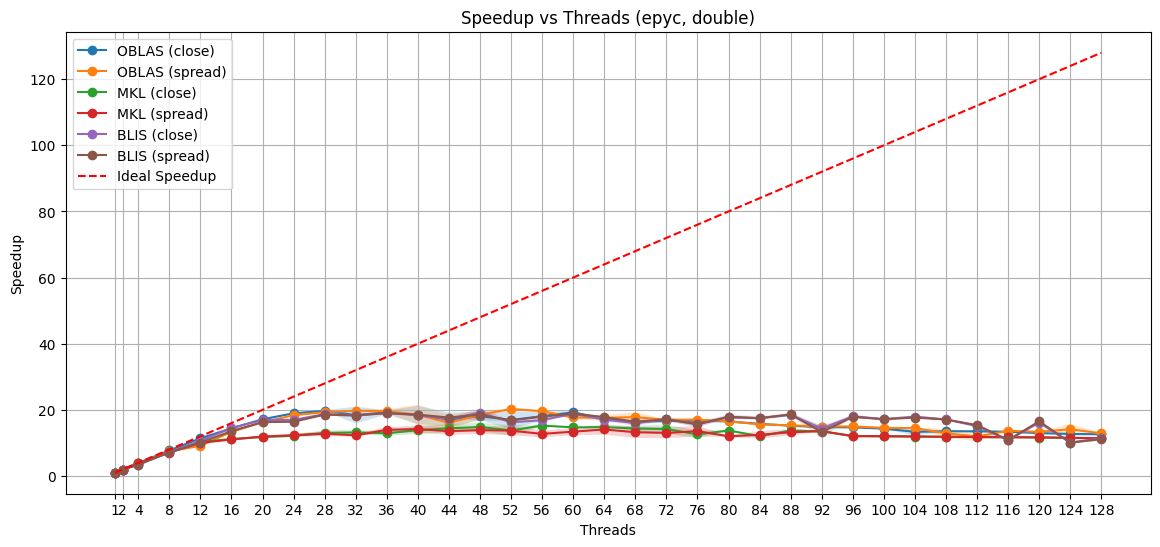

In [144]:
plot_core('epyc', 'double')

# THIN

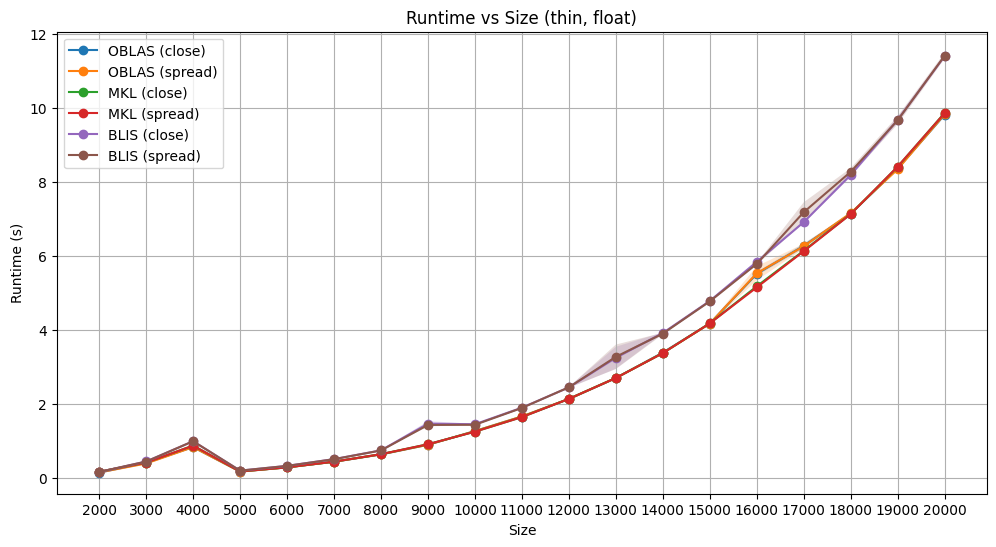

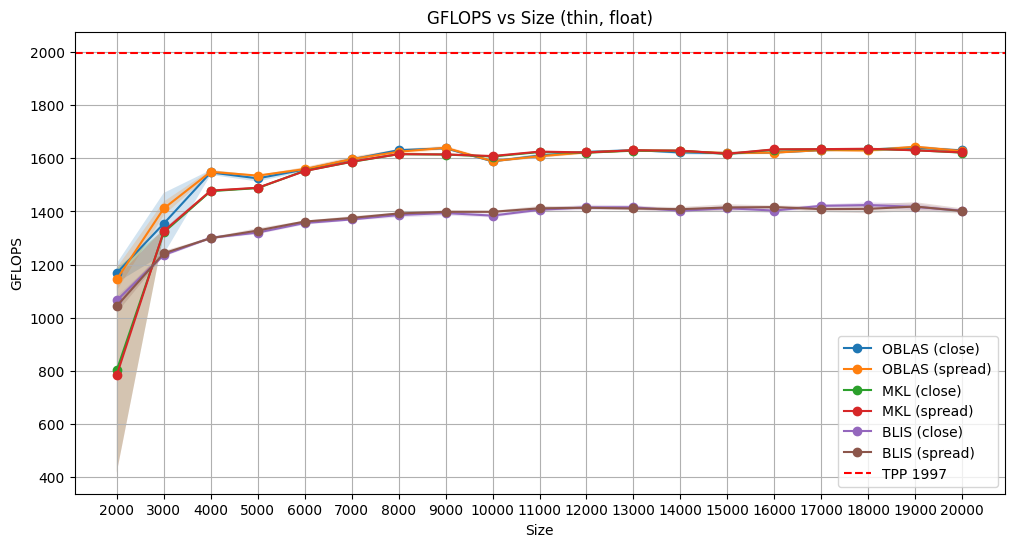

In [145]:
plot_size('thin', 'float')

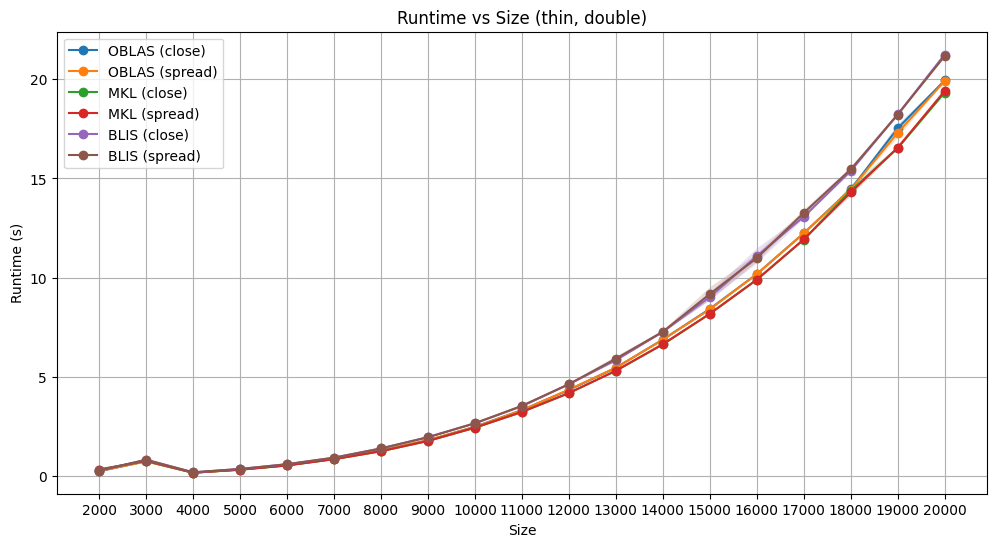

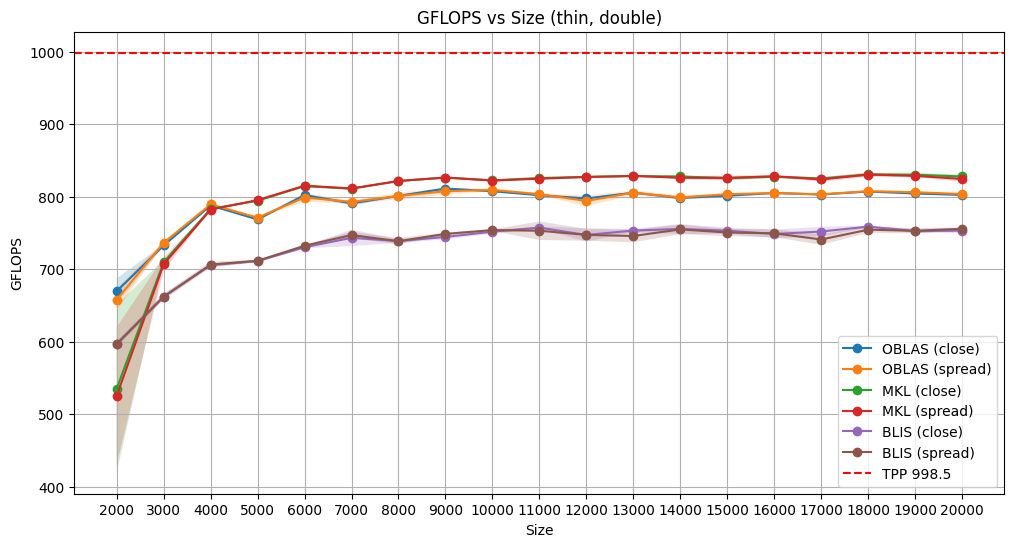

In [146]:
plot_size('thin', 'double')

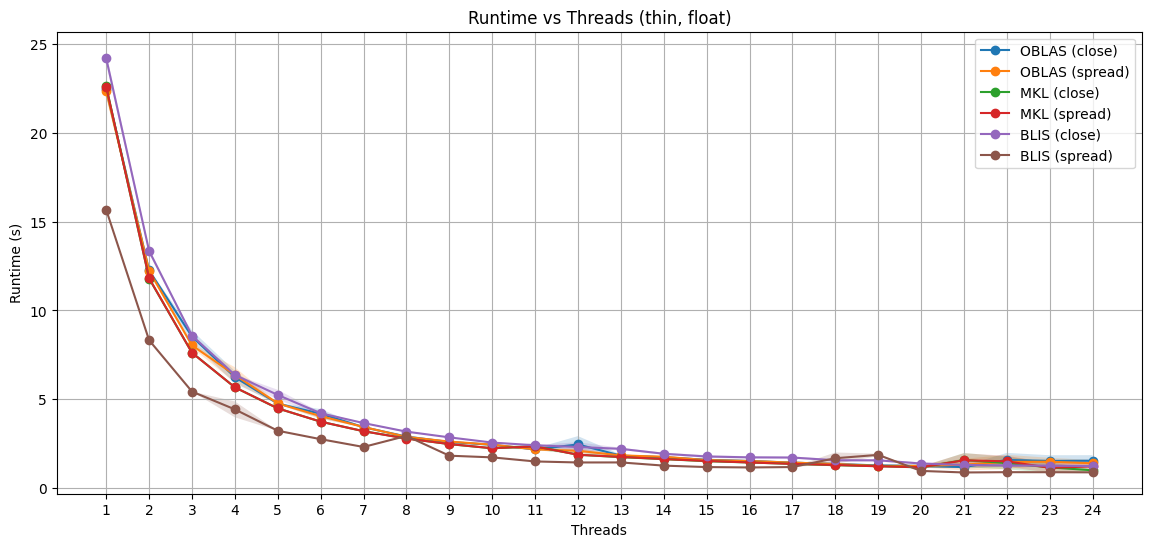

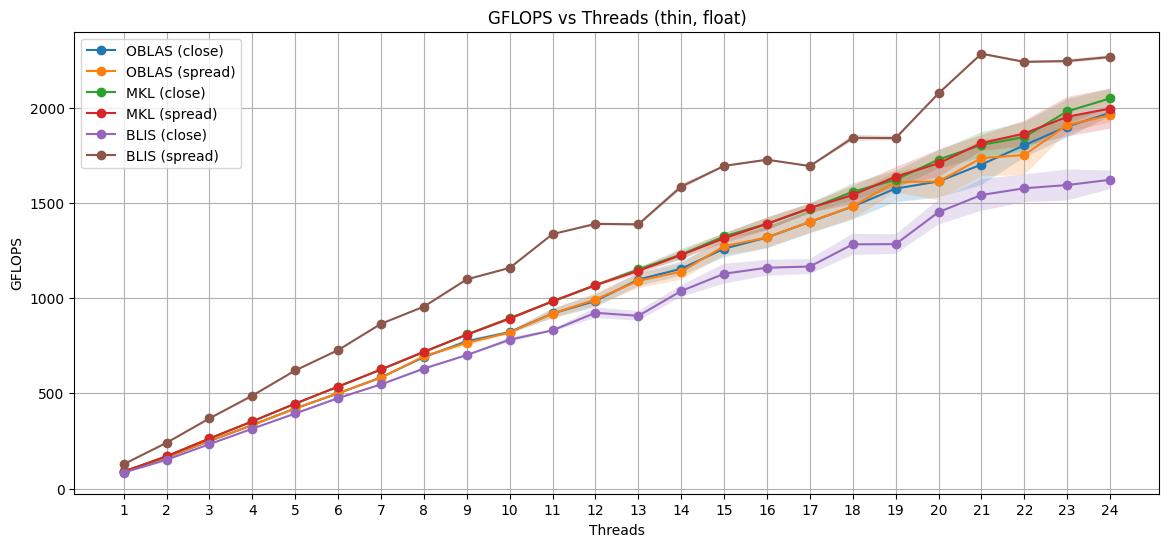

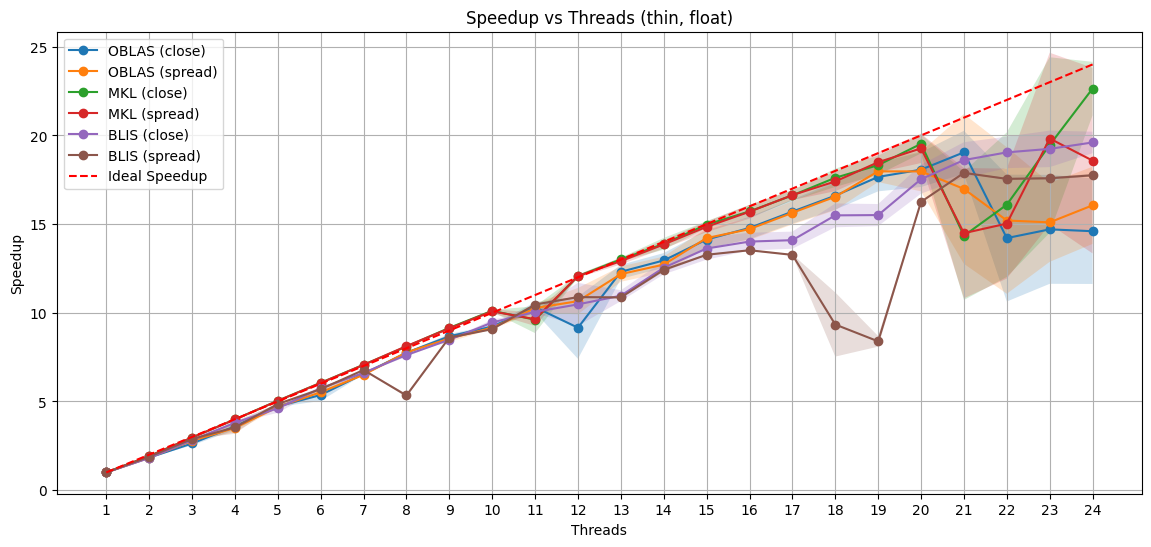

In [147]:
plot_core('thin', 'float')

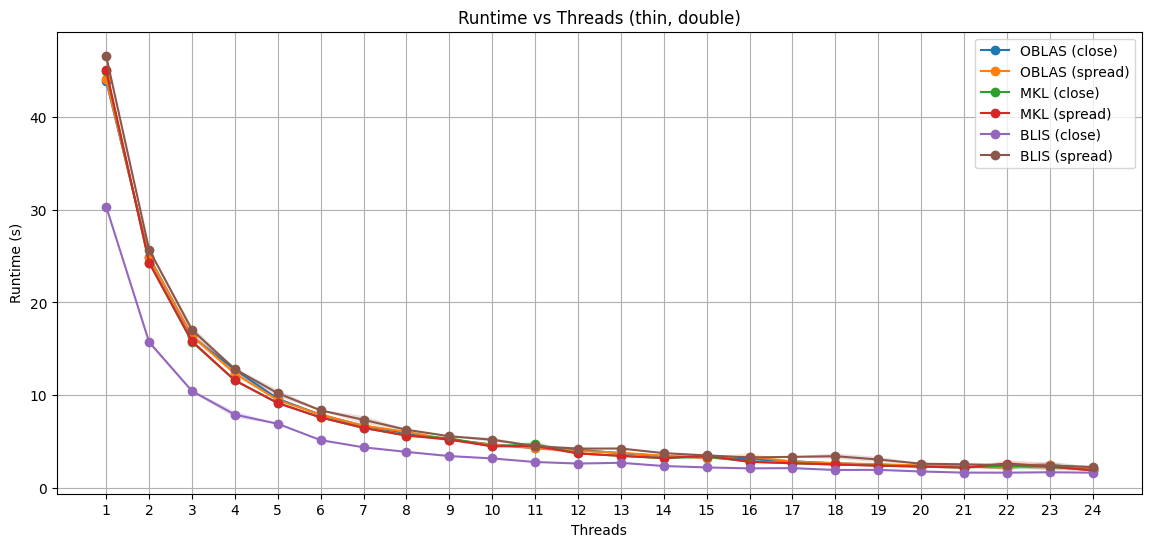

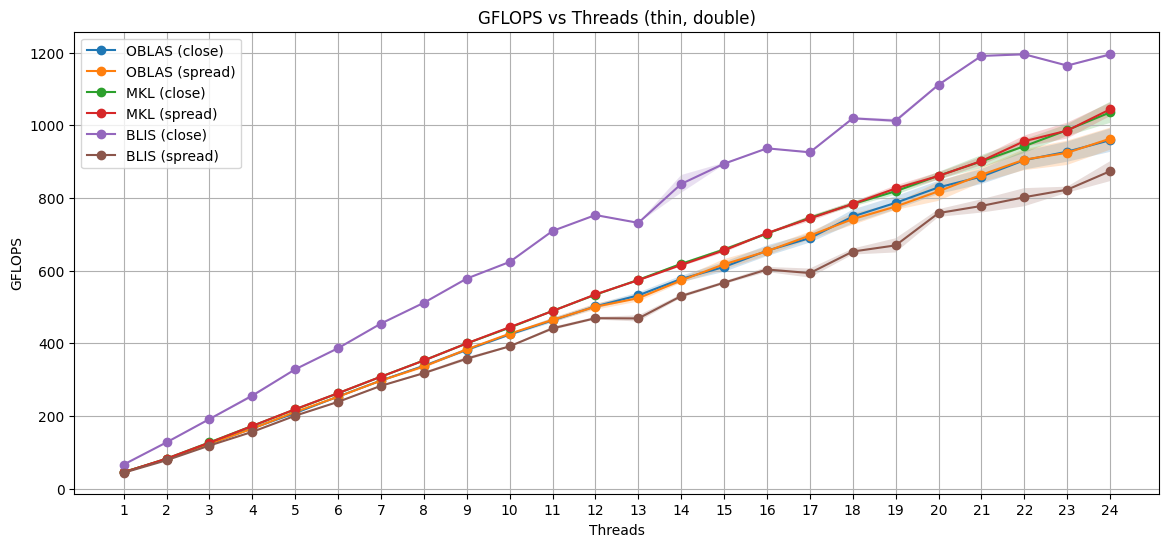

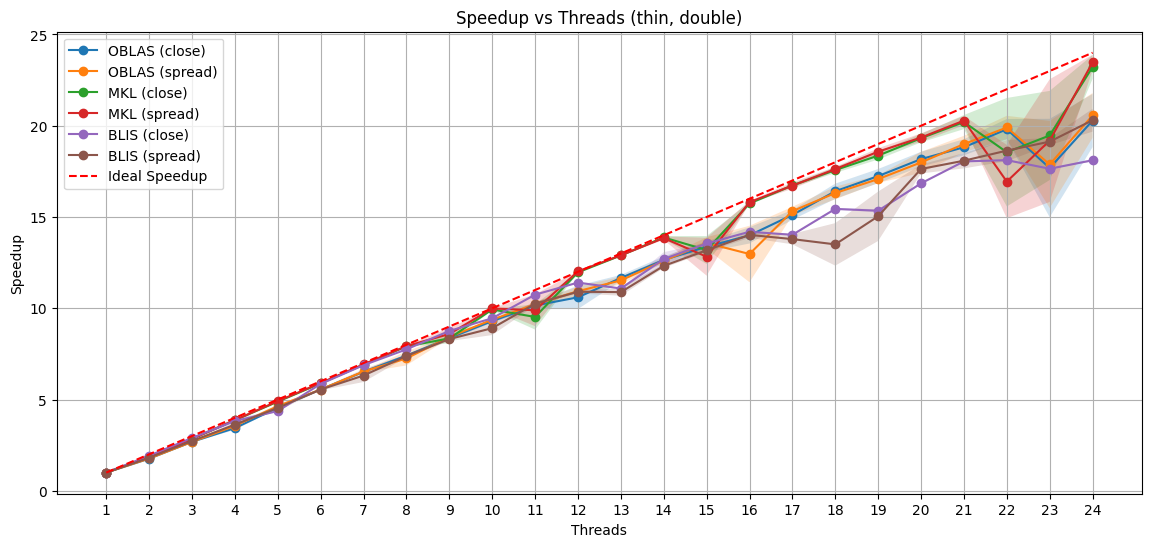

In [148]:
plot_core('thin', 'double')